# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 12

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [714]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

from copy import copy

import numpy as np
from numpy.random import rand, randint, permutation

import random

from thinkstats2 import RandomSeed

import thinkplot

In [785]:
HIST_LENGTH = 1

In [800]:
class Agent:
    
    if HIST_LENGTH == 1:
        keys = [(None,),
                ('C',),
                ('D',)]
    else:
        keys = [(None, None),
                (None, 'C'),
                (None, 'D'),
                ('C', 'C'),
                ('C', 'D'),
                ('D', 'C'),
                ('D', 'D')]
    
    def __init__(self, values):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        
    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0
        
    def past_responses(self, num=HIST_LENGTH):
        """Select the given number of most recent responses.
        
        num: integer number of responses
        
        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])
    
    def respond(self, other):
        """Choose a response based on the opponent's recent responses.
        
        other: Agent
        
        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp
        
    def append(self, resp, pay):
        """Update based on the last response and payoff.
        
        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay
        
    prob_mutate = 0.05
    
    def copy(self):
        """Make a copy of this agent.
        """
        if np.random.random() > self.prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values)
    
    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.
        
        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

In [801]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None,): 'C', ('C',): 'C', ('D',): 'C'}

In [802]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None,): 'D', ('C',): 'D', ('D',): 'D'}

In [803]:
tft = Agent('CCDCDCD')
tft.responses

{(None,): 'C', ('C',): 'C', ('D',): 'D'}

In [804]:
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD


In [805]:
class Tournament:
    num_rounds = 10
        
    payoffs = {('C', 'C'): (3, 3),
              ('C', 'D'): (0, 5),
              ('D', 'C'): (5, 0),
              ('D', 'D'): (1, 1)}
    
    def play(self, agent1, agent2):
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            #print(resp1, resp2, pay1, pay2)
            
        return agent1.score, agent2.score
        
    def melee(self, agents):
        agents = np.random.permutation(agents)
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
        
        matches = np.zeros(n)
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
            matches[i] += 1
            matches[j] += 1
        
        assert np.all(matches==2)
        for i in i_row:
            agents[i].fitness = totals[i] / matches[i]

In [806]:
tour = Tournament()
tour.play(all_d, tft)

(14, 9)

In [807]:
agents = [all_c, all_d, tft]
agents

In [808]:
tour.melee(agents)

In [809]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 15.0
DDDDDDD 32.0
CCDCDCD 19.5


In [810]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [811]:
from scipy.stats import zscore

def prob_surv(scores):
    zs = zscore(scores)
    zs = np.where(np.isnan(zs), 4, zs)
    return logistic(zs, A=0.5, B=2, K=0.9)

In [812]:
def prob_surv(scores):
    return logistic(scores, A=0.7, B=0.1, M=30, K=0.9)

In [813]:
scores = np.linspace(0, 50)
scores

array([  0.   ,   1.02 ,   2.041,   3.061,   4.082,   5.102,   6.122,
         7.143,   8.163,   9.184,  10.204,  11.224,  12.245,  13.265,
        14.286,  15.306,  16.327,  17.347,  18.367,  19.388,  20.408,
        21.429,  22.449,  23.469,  24.49 ,  25.51 ,  26.531,  27.551,
        28.571,  29.592,  30.612,  31.633,  32.653,  33.673,  34.694,
        35.714,  36.735,  37.755,  38.776,  39.796,  40.816,  41.837,
        42.857,  43.878,  44.898,  45.918,  46.939,  47.959,  48.98 ,  50.   ])

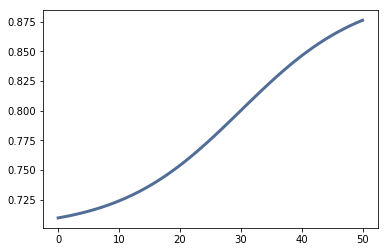

In [814]:
probs = prob_surv(scores)
thinkplot.plot(scores, probs)

In [815]:
class Simulation:
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=100):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        fits = self.get_fitnesses()
        ps = prob_surv(fits)
        
        # see who dies
        index_dead = self.choose_dead(ps)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, fits):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        fits: array of fitnesses
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [816]:
def make_random_agents(n):
    agents = [Agent(np.random.choice(['C', 'D'], size=7)) 
              for _ in range(n)]
    return agents

In [817]:
def make_identical_agents(n, values):
    agents = [Agent(values) for _ in range(n)]
    return agents

In [818]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        thinkplot.plot(self.metrics, **options)

In [819]:
class Niceness(Instrument):
    """Computes average niceness."""
    label = 'Niceness'
        
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [820]:
class Opening(Instrument):
    """Computes ."""
    label = 'Opening'
        
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [821]:
class Provocability(Instrument):
    """Computes ."""
    label = 'Provocability'
        
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

In [822]:
class Forgiveness(Instrument):
    """Computes ."""
    label = 'Forgiveness'
        
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

In [844]:
tour = Tournament()

agents = make_identical_agents(100, list('DDDDDDD'))
sim = Simulation(tour, agents)

sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Provocability())
sim.add_instrument(Forgiveness())

In [845]:
sim.run(5000)

0.522

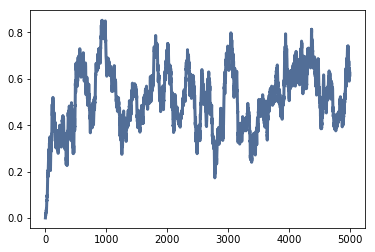

In [846]:
sim.plot(0)
np.mean(sim.instruments[0].metrics[1000:])

0.421

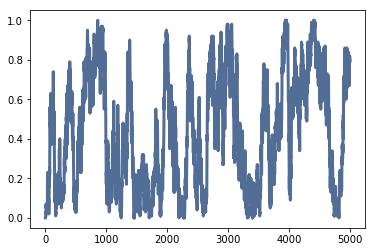

In [847]:
sim.plot(1)
np.mean(sim.instruments[1].metrics[1000:])

0.035

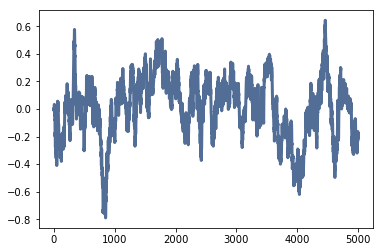

In [837]:
sim.plot(2)
np.mean(sim.instruments[2].metrics[1000:])

-0.043

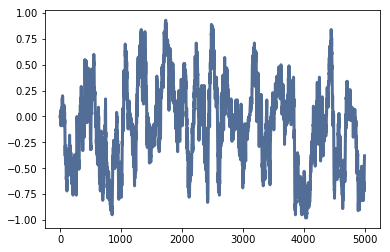

In [839]:
sim.plot(3)
np.mean(sim.instruments[3].metrics[1000:])

In [840]:
for agent in sim.agents:
    print(agent.values)

['D', 'D', 'C', 'C', 'C', 'D', 'D']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['D', 'C', 'C', 'D', 'D', 'D', 'C']
['D', 'C', 'C', 'C', 'C', 'D', 'D']
['D', 'D', 'D', 'D', 'C', 'C', 'C']
['D', 'D', 'D', 'D', 'C', 'C', 'C']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['C', 'D', 'C', 'D', 'D', 'D', 'D']
['D', 'C', 'C', 'D', 'C', 'D', 'C']
['D', 'D', 'D', 'D', 'C', 'C', 'C']
['D', 'C', 'C', 'D', 'D', 'D', 'C']
['D', 'D', 'D', 'D', 'C', 'C', 'D']
['D', 'C', 'C', 'C', 'C', 'D', 'D']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['D', 'C', 'C', 'D', 'D', 'D', 'D']
['D', 'C', 'C', 'C', 'D', 'D', 'C']
['D', 'C', 'C', 'D', 'C', 'D', 'C']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['D', 'D', 'D', 'D', 'C', 'C', 'C']
['D', 'D', 'D', 'D', 'C', 'C', 'C']
['D', 'C', 'C', 'C', 'D', 'D', 'D']
['D', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'C', 'D', 'D', 'D']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['D', 'D', 'C', 'C', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D

In [841]:
tft.values

'CCDCDCD'

In [842]:
responses = [''.join(agent.values) for agent in sim.agents]

In [843]:
from pandas import Series
Series(responses).value_counts()

DCCDDDD    18
DDDDCCC    13
DDCCCDC     9
DCDCCDD     9
DCCDDDC     8
DCCDCDC     8
CCCDDDD     6
DCCCCDC     5
DCCCCDD     3
DCCCDDC     3
CDCDDDD     3
DCCCDDD     3
DDDCCCC     2
DDCDCDD     2
CCCCDDD     2
DDCCCDD     1
DCCDDCD     1
DCDDCDC     1
DDDDCCD     1
CCCCCDC     1
DCDDDDD     1
dtype: int64